<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Alumno: Fabian Andres Uribe Guerra
##Desafio 5



### 1. Datos

In [1]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

In [3]:
import requests

url = "https://convai.io/data/data_tolokers.json" #Link ejercicio
response = requests.get(url)

with open("data_tolokers.json", "wb") as f:
    f.write(response.content)

In [4]:
import json

text_file = "data_tolokers.json"
with open(text_file) as f:
    data = json.load(f)

In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [9]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    return txt.strip()


for line in data:
    for i in range(len(line['dialog']) - 1):
        input_text = clean_text(line['dialog'][i]['text'])
        output_text = clean_text(line['dialog'][i + 1]['text'])

        if len(input_text) >= max_len or len(output_text) >= max_len:
            continue

        # Agregar tokens especiales
        output_sentence = output_text + ' '
        output_sentence_input = ' ' + output_text

        input_sentences.append(input_text)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 12780


In [13]:
input_sentences[0], output_sentences[1], output_sentences_inputs[2]

('hello', 'what do you do ', ' hello how are you')

### 2 - Preprocesamiento

In [14]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000
# Vamos a necesitar un tokenizador para cada idioma

In [15]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenizador de inglés
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(input_sentences + ["<sos>", "<eos>"] + output_sentences_inputs)


input_integer_seq = tokenizer.texts_to_sequences(input_sentences)
output_input_integer_seq = tokenizer.texts_to_sequences(output_sentences_inputs)
output_integer_seq = tokenizer.texts_to_sequences(output_sentences)


# Obtenemos longitudes máximas de secuencias
max_input_len = max(len(seq) for seq in input_integer_seq)
max_out_len = max(len(seq) for seq in output_integer_seq)

# Convertimos las secuencias a matrices con padding
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len)
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len)

# Creamos diccionarios de índices de palabras
word2idx_inputs = tokenizer.word_index
num_words_output = len(tokenizer.word_index) + 1  # +1 por el índice 0
word2idx_outputs = word2idx_inputs  # Como es el mismo idioma, usan el mismo vocabulario

print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in encoder_input_sequences)
print("Sentencia de entrada más larga:", max_input_len)

max_out_len = max(len(sen) for sen in decoder_input_sequences)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 2946
Sentencia de entrada más larga: 10
Sentencia de salida más larga: 10


In [16]:
if '<sos>' not in word2idx_inputs or '<eos>' not in word2idx_inputs:
    print("El token '<sos>' o '<eos>' no está en el vocabulario.")
else:
    print(f"'<sos>' tiene el índice: {word2idx_inputs['<sos>']}")


'<sos>' tiene el índice: 2513


In [17]:
if '<sos>' in word2idx_inputs and '<eos>' in word2idx_inputs:
    print(f"'<sos>' tiene el índice: {word2idx_inputs['<sos>']}")
    print(f"'<eos>' tiene el índice: {word2idx_inputs['<eos>']}")
else:
    print("Error al añadir '<sos>' o '<eos>' al vocabulario.")


'<sos>' tiene el índice: 2513
'<eos>' tiene el índice: 2514


A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [19]:
print("Cantidad de rows del dataset:", len(input_integer_seq))
print("encoder_input_sequences shape:", encoder_input_sequences.shape)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 12780
encoder_input_sequences shape: (12780, 10)
decoder_input_sequences shape: (12780, 10)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [20]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(12780, 10, 2947)

### 3 - Preparar los embeddings

In [21]:
!pip install gdown

# Descargar el archivo grande desde Google Drive
import gdown

# URL del archivo
url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
output = 'gloveembedding.pkl'

# Descargar el archivo con gdown
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&confirm=t&uuid=fd3f237f-ae30-4dfd-8024-8805253c015f
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:05<00:00, 87.9MB/s]


'gloveembedding.pkl'

In [22]:
import pickle

# Cargar el archivo gloveembedding.pkl
with open('gloveembedding.pkl', 'rb') as f:
    glove_embeddings = pickle.load(f)

print("Embeddings cargados correctamente.")


Embeddings cargados correctamente.


In [23]:
print(glove_embeddings.dtype)  # Ver el tipo de dato y estructura
print(glove_embeddings.shape)  # Ver el tamaño del array


[('word', '<U60'), ('embedding', '<f4', (50,))]
(1193514,)


In [24]:
# Mostrar las primeras 5 palabras y sus vectores de embeddings
for i in range(5):
    print(f"Palabra: {glove_embeddings[i]['word']}")
    print(f"Vector: {glove_embeddings[i]['embedding']}\n")


Palabra: <user>
Vector: [ 0.78704   0.72151   0.29148  -0.056527  0.31683   0.47172   0.023461
  0.69568   0.20782   0.60985  -0.22386   0.7481   -2.6208    0.20117
 -0.48104   0.12897   0.035239 -0.24486  -0.36088   0.026686  0.28978
 -0.10698  -0.34621   0.021053  0.54514  -1.0958   -0.274     0.2233
  1.0827   -0.029018 -0.84029   0.58619  -0.36511   0.34016   0.89615
  0.32757   0.24267   0.68404  -0.34374   0.13583  -2.2162   -0.42537
  0.46157   0.88626  -0.22014   0.025599 -0.38615   0.080107 -0.075323
 -0.61461 ]

Palabra: .
Vector: [ 0.68661  -1.0772    0.011114 -0.24075  -0.3422    0.64456   0.54957
  0.30411  -0.54682   1.4695    0.43648  -0.34223  -2.7189    0.46021
  0.016881  0.13953   0.020913  0.050963 -0.48108  -1.0764   -0.16807
 -0.014315 -0.55055   0.67823   0.24359  -1.3179   -0.036348 -0.228
  1.0337   -0.53221  -0.52934   0.35537  -0.44911   0.79506   0.56947
  0.071642 -0.27455  -0.056911 -0.42961  -0.64412  -1.3495    0.23258
  0.25383  -0.10226   0.65824   0.1

In [25]:
def buscar_vector(palabra, embeddings):
    resultado = embeddings[embeddings['word'] == palabra]
    if len(resultado) > 0:
        return resultado['embedding'][0]  # Devolver el primer resultado encontrado
    else:
        return None

# Ejemplo de uso
vector_palabra = buscar_vector('the', glove_embeddings)
if vector_palabra is not None:
    print(f"Vector para 'the': {vector_palabra}")
else:
    print("La palabra no está en los embeddings.")


Vector para 'the': [ 2.5320e-01 -1.4884e-02  5.9371e-01  1.5902e-01  1.2754e-01  2.2428e-01
  8.9421e-01  3.6396e-01 -3.1339e-01 -5.1857e-01  2.9637e-01 -4.1098e-02
 -6.4555e+00  3.2260e-01  3.7280e-01 -6.1690e-01  4.6744e-01  5.0600e-01
  3.1950e-02  1.0155e-01 -1.9615e-01  1.3364e-01 -2.7140e-01 -4.1728e-01
  7.7940e-03  1.3573e-01 -7.2992e-02  2.5208e-01  5.1148e-01  1.5120e-01
  8.4398e-02 -2.4791e-01 -1.5913e-01  1.5005e-01  7.7243e-01  3.6632e-01
 -9.8310e-02 -6.4317e-02 -7.1983e-04 -1.5231e-01 -1.4604e+00 -3.1696e-01
 -4.1762e-01  7.3363e-02  3.2043e-01  3.4324e-01  1.0895e-02 -2.8932e-01
  4.5493e-01  1.8659e-01]


In [26]:
# Verificar la dimensionalidad de un vector de embedding
print(f"Dimensionalidad del vector: {glove_embeddings[0]['embedding'].shape}")


Dimensionalidad del vector: (50,)


In [27]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [28]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [29]:
# Crear la Embedding matrix de las secuencias

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 80


In [30]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(2946, 50)

### 4 - Entrenar el modelo

Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.



In [31]:
max_input_len

10

In [32]:
#Opcion1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

n_units = 128
dropout_rate = 0.2

# define training encoder
#encoder_inputs = Input(shape=(max_input_len))
# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

#encoder = LSTM(n_units, return_state=True)
encoder = LSTM(n_units, return_state=True, dropout=dropout_rate)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 10, 50)    │    147,300 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 128)   │    377,216 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │     91,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 10, 128), │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 2947)  │    380,163 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,127,911 (4.30 MB)

 Trainable params: 980,611 (3.74 MB)

 Non-trainable params: 147,300 (575.39 KB)

In [33]:
num_words_output

2947

In [34]:
#Opcion2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

n_units = 128
dropout_rate = 0.2
# define training encoder
#encoder_inputs = Input(shape=(max_input_len))
# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)
#input_dim = np.max(encoder_input_sequences) + 1
input_dim = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)  # +1 para incluir el índice 0
print('input_dim')
print(input_dim)
encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador  input_dim=nb_words
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)
 #encoder = LSTM(n_units, return_state=True)
encoder = LSTM(n_units, return_state=True, dropout=dropout_rate)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]


# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
#decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=50, input_length=max_out_len)
#decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=num_words_output, input_length=max_out_len)

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

input_dim
2947


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 10, 50)    │    147,300 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 10, 50)    │    147,350 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 128),     │     91,648 │ embedding_2[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 10, 128), │     91,648 │ embedding_3[0][0… │
│                     │ (None, 128),      │            │ lstm_2[0][1],     │
│                     │ (None, 128)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10, 2947)  │    380,163 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 858,109 (3.27 MB)

 Trainable params: 710,809 (2.71 MB)

 Non-trainable params: 147,300 (575.39 KB)

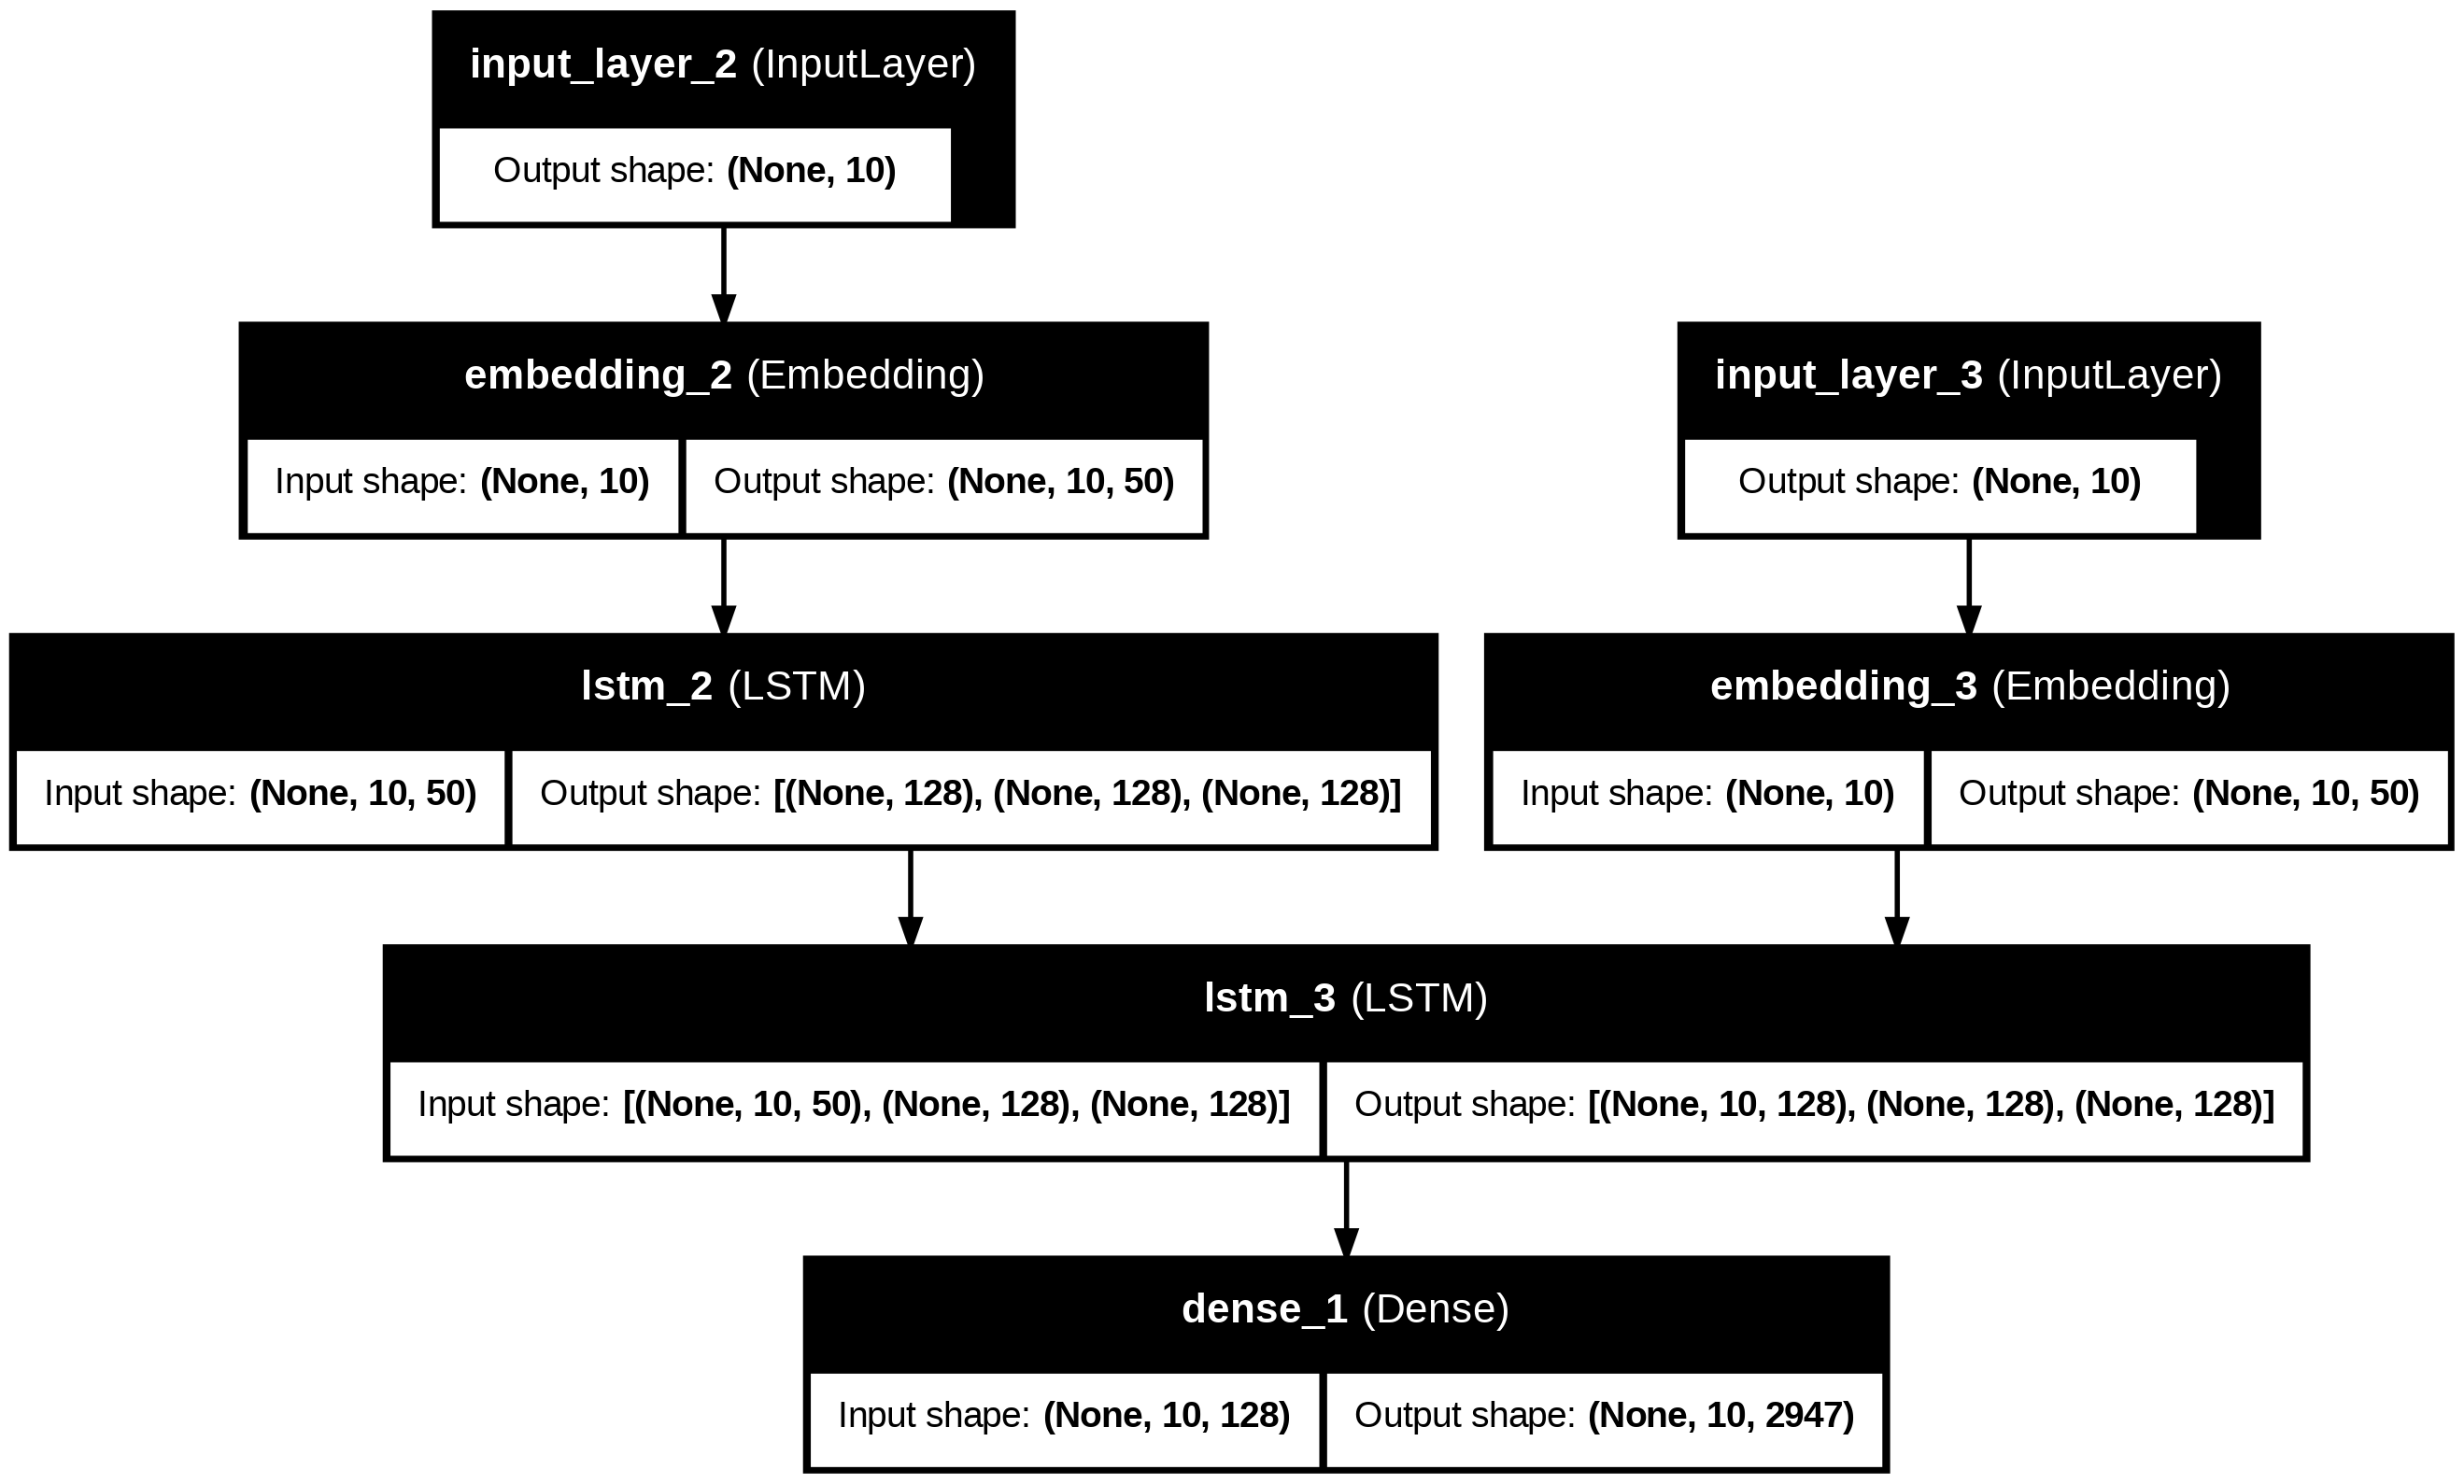

In [35]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

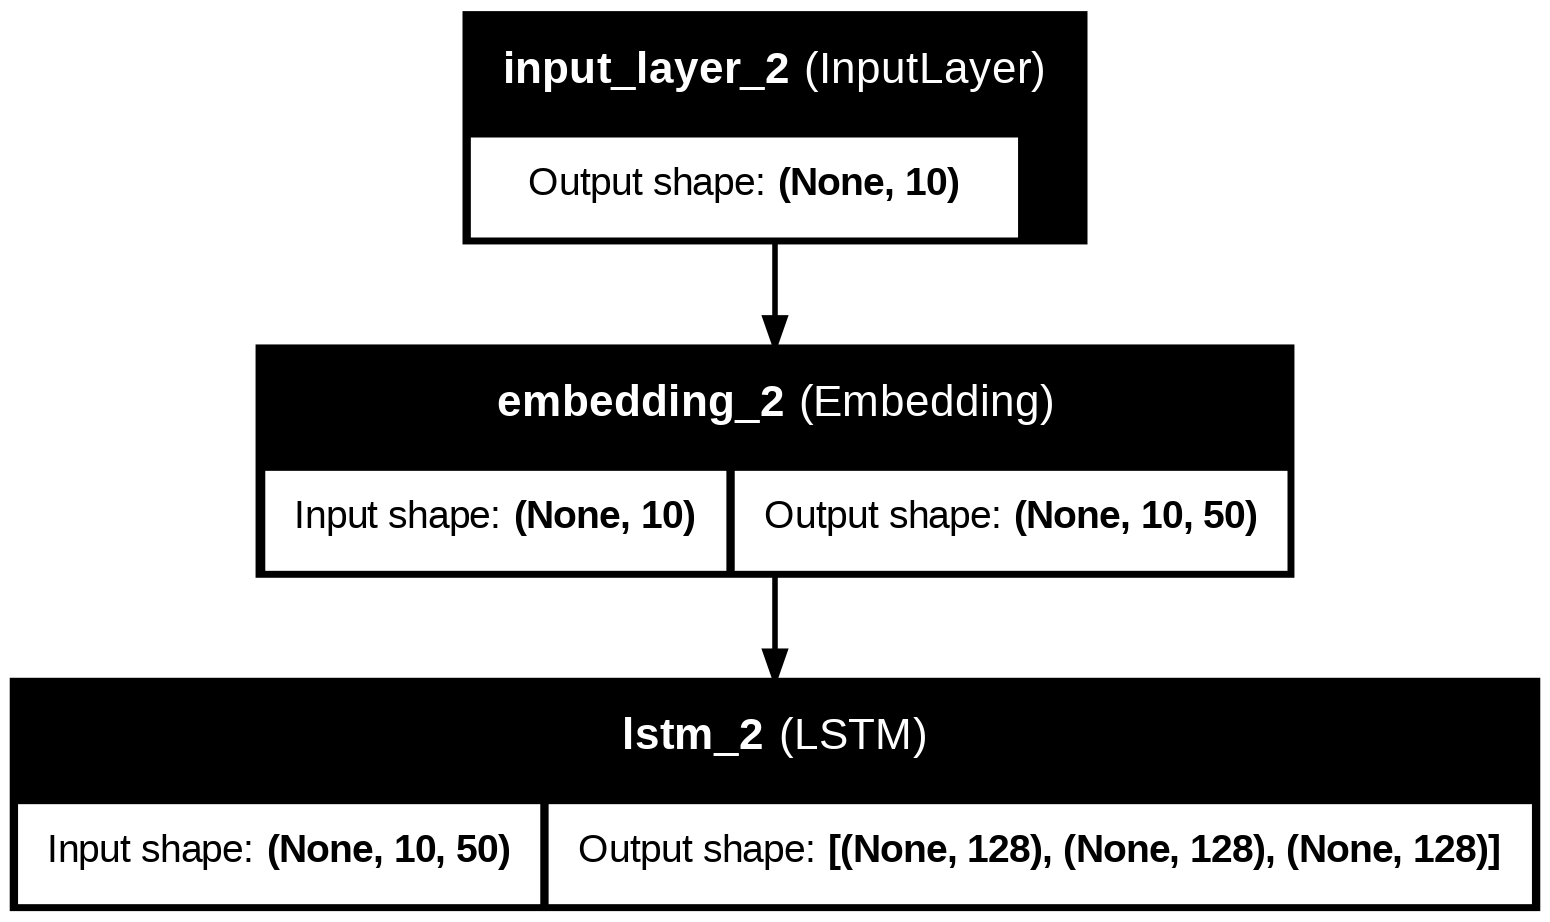

In [36]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

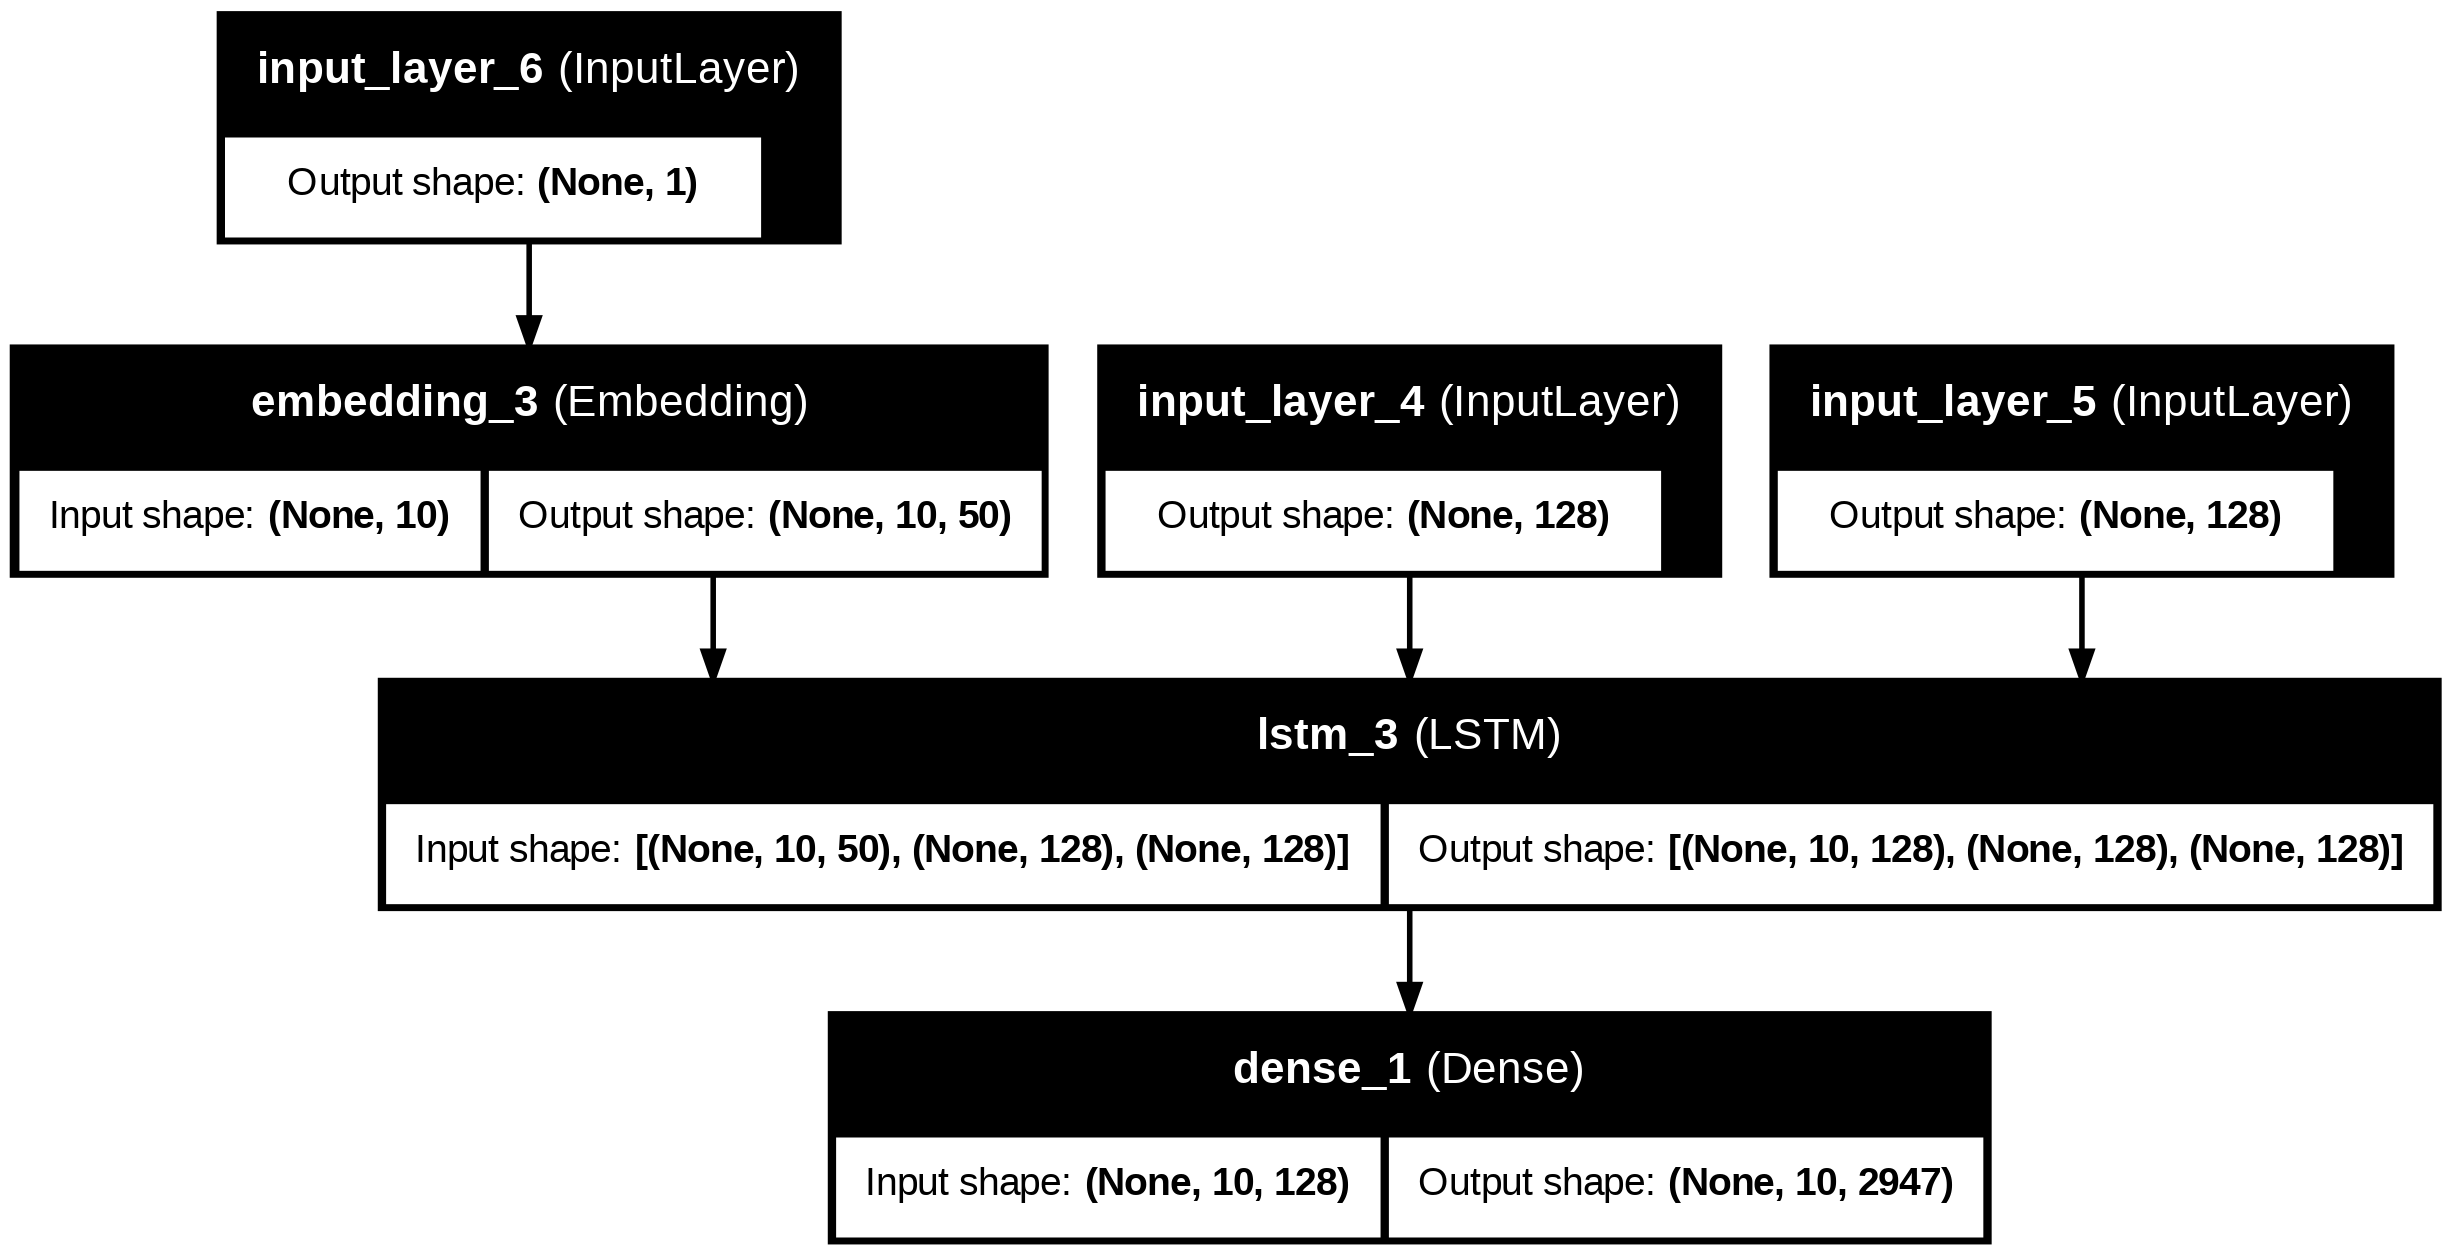

In [37]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [38]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5846 - loss: 3.6547 - val_accuracy: 0.6103 - val_loss: 2.3798
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6177 - loss: 2.2673 - val_accuracy: 0.6140 - val_loss: 2.3115
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6218 - loss: 2.1884 - val_accuracy: 0.6151 - val_loss: 2.2767
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6274 - loss: 2.1193 - val_accuracy: 0.6185 - val_loss: 2.2578
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6280 - loss: 2.0972 - val_accuracy: 0.6209 - val_loss: 2.2407
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6316 - loss: 2.0613 - val_accuracy: 0.6210 - val_loss: 2.2275
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6320 - loss: 2.0458 - val_accuracy: 0.6207 - val_loss: 2.2194
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6344 - loss: 2.0133 - val_acc

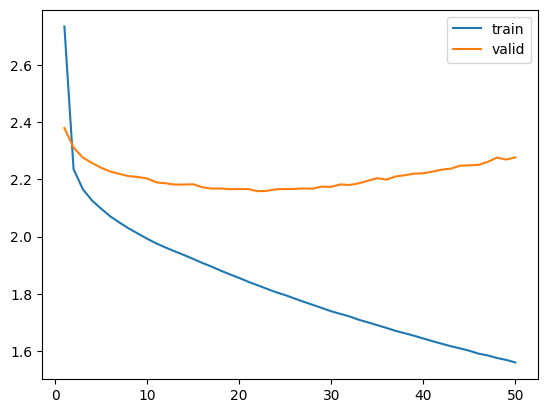

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

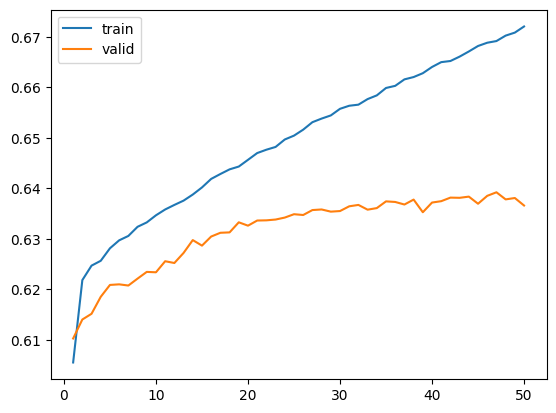

In [41]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [42]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [43]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [44]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
print(input_seq)
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

[[ 0  0  0  0  0  0  4  2 10 70]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
-
Input: do you like music
Response: i do not i have i to a vet


In [45]:
#input_test = "Where are you from?"
#input_test = "Do you read?"
#input_test = "Do you have any pet?"
input_test = "Where are you from?"
print('Input:', input_test)
integer_seq_test = tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Where are you from?
Representacion en vector de tokens de ids [33, 5, 2, 43]
Padding del vector: [[ 0  0  0  0  0  0 33  5  2 43]]
Input: Where are you from?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Response: i m not i am a i am a


In [46]:
input_test = "Do you have any pet?"
print('Input:', input_test)
integer_seq_test = tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Do you have any pet?
Representacion en vector de tokens de ids [4, 2, 12, 60, 415]
Padding del vector: [[  0   0   0   0   0   4   2  12  60 415]]
Input: Do you have any pet?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Response: i am not i am not am am woman


In [47]:
input_test = "Do you read?"
print('Input:', input_test)
integer_seq_test = tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Do you read?
Representacion en vector de tokens de ids [4, 2, 98]
Padding del vector: [[ 0  0  0  0  0  0  0  4  2 98]]
Input: Do you read?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Response: i do not i not a i a it
